In [19]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from opacus import PrivacyEngine
from opacus.accountants.analysis import rdp as privacy_analysis
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

In [3]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

RANDOM_SEED = 42
set_random_seeds(RANDOM_SEED)

Random seed set to 42


# Import Dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# Data Cleaning

# Data Preprocessing

In [5]:
y = y.iloc[:, 0]
# Strip spaces and remove periods
y = y.str.strip().str.replace('.', '', regex=False)

# Map both <=50K and <50K to 0; >=50K and >50K to 1
y = y.replace({
    '<=50K': 0,
    '<50K': 0,
    '>=50K': 1,
    '>50K': 1
})

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

## Fairness Metrics Function

In [6]:
def fairness_metrics(X_test, y_true, y_pred, feature):
    """
    Calculate fairness metrics for a specific sensitive feature.
    
    - Returns Positive Rates, TPR, FPR, and accuracy for each group.
    - Returns fairness metrics: disparate impact, equal opportunity difference, and equalized odds difference.
    
    Privileged groups are Male (for sex) and White (for race).
    Protected groups are Female (for sex) and Non-White (for race).
    """
    df_eval = X_test.copy()
    df_eval['y_true'] = y_true.values if hasattr(y_true, 'values') else y_true
    df_eval['y_pred'] = y_pred

    metrics = []
    
    if feature == 'sex':
        groups = ['Male', 'Female']
    elif feature == 'race':
        # combine all non-White as 'Non-White'
        df_eval['race_grouped'] = df_eval['race'].apply(lambda x: 'White' if x == 'White' else 'Non-White')
        groups = ['White', 'Non-White']
        feature = 'race_grouped'
    else:
        groups = df_eval[feature].unique()

    for g in groups:
        mask = df_eval[feature] == g
        y_t = df_eval.loc[mask, 'y_true']
        y_p = df_eval.loc[mask, 'y_pred']

        # Positive prediction rate (Demographic Parity)
        pos_rate = np.mean(y_p)

        # True Positive Rate (Equal Opportunity)
        tp = np.sum((y_p == 1) & (y_t == 1))
        fn = np.sum((y_p == 0) & (y_t == 1))
        tpr = tp / (tp + fn + 1e-10)

        # False Positive Rate (Equalized Odds)
        fp = np.sum((y_p == 1) & (y_t == 0))
        tn = np.sum((y_p == 0) & (y_t == 0))
        fpr = fp / (fp + tn + 1e-10)

        # Accuracy
        acc = np.mean(y_p == y_t)

        metrics.append({
            'group': g,
            'positive_rate': pos_rate,
            'TPR': tpr,
            'FPR': fpr,
            'accuracy': acc
        })

    df_metrics = pd.DataFrame(metrics)
    print(f"\n=== Fairness by {feature} ===")
    print(df_metrics.to_string(index=False))

    # Privileged / Protected groups
    privileged = 'Male' if feature == 'sex' else 'White'
    protected = 'Female' if feature == 'sex' else 'Non-White'

    # Extract values
    p_priv = df_metrics.loc[df_metrics['group'] == privileged, 'positive_rate'].values[0]
    p_prot = df_metrics.loc[df_metrics['group'] == protected, 'positive_rate'].values[0]

    tpr_priv = df_metrics.loc[df_metrics['group'] == privileged, 'TPR'].values[0]
    tpr_prot = df_metrics.loc[df_metrics['group'] == protected, 'TPR'].values[0]

    fpr_priv = df_metrics.loc[df_metrics['group'] == privileged, 'FPR'].values[0]
    fpr_prot = df_metrics.loc[df_metrics['group'] == protected, 'FPR'].values[0]

    # Disparate Impact
    disparate_impact = (p_prot + 1e-10) / (p_priv + 1e-10)

    # Equal Opportunity Difference (TPR difference)
    equal_opp_diff = tpr_prot - tpr_priv

    # Equalized Odds Differences
    equalized_odds_tpr_diff = tpr_prot - tpr_priv
    equalized_odds_fpr_diff = fpr_prot - fpr_priv

    print("\n=== GROUP FAIRNESS DISPARITIES ===")
    print(f"Privileged group: {privileged}, Protected group: {protected}")
    print(f"Disparate Impact: {disparate_impact:.4f}")
    print(f"Equal Opportunity Difference (TPR diff): {equal_opp_diff:.4f}")
    print(f"Equalized Odds Differences: TPR diff={equalized_odds_tpr_diff:.4f}, "
          f"FPR diff={equalized_odds_fpr_diff:.4f}")

    disparities = {
        'disparate_impact': disparate_impact,
        'equal_opportunity_difference': equal_opp_diff,
        'equalized_odds_tpr_diff': equalized_odds_tpr_diff,
        'equalized_odds_fpr_diff': equalized_odds_fpr_diff
    }

    return df_metrics, disparities

def evaluate_model_full(name, model, X_model_input, y_true, X_sensitive, 
                        fairness_metrics_func=fairness_metrics):
    """
    Evaluate a model with standard metrics and fairness metrics.
    
    Works with both sklearn models and PyTorch models.
    """
    # Detect if PyTorch model
    is_torch_model = isinstance(model, torch.nn.Module)

    if is_torch_model:
        # Ensure tensor input
        if not torch.is_tensor(X_model_input):
            X_model_input = torch.tensor(X_model_input, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            outputs = model(X_model_input)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
    else:
        # sklearn model
        y_pred = model.predict(X_model_input)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_model_input)[:, 1]
        else:
            probs = y_pred

    # Standard metrics
    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')

    print(f"\n{'='*70}")
    print(f"EVALUATION: {name}")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"AUC-ROC Score: {auc:.4f}")

    # Fairness metrics
    sex_metrics = race_metrics = None
    if fairness_metrics_func and X_sensitive is not None:
        if 'sex' in X_sensitive.columns:
            sex_metrics, sex_disparities = fairness_metrics_func(X_sensitive, y_true, y_pred, 'sex')
        if 'race' in X_sensitive.columns:
            race_metrics, race_disparities = fairness_metrics_func(X_sensitive, y_true, y_pred, 'race')

    return {
        "name": name,
        "accuracy": acc,
        "auc": auc,
        "y_pred": y_pred,
        "sex_metrics": sex_metrics,
        "race_metrics": race_metrics,
        "sex_disparities": sex_disparities,
        "race_disparities": race_disparities 
    }

## Pytorch Model Definition

In [7]:
class LogisticRegressionModel(nn.Module):
    """Simple logistic regression model for binary classification."""
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.linear(x)

# BASELINE MODEL (NO DIFFERENTIAL PRIVACY)

In [8]:
def train_baseline_model(X_train, y_train, X_test, y_test, 
                         max_iter=1000, random_state=RANDOM_SEED):
    """
    Train a baseline logistic regression model without any privacy protection.
    
    Args:
        X_train, y_train: Training data (pandas DataFrames/Series)
        X_test, y_test: Test data
        max_iter: Maximum iterations for sklearn LogisticRegression
        random_state: Random seed
        
    Returns:
        model: Trained sklearn pipeline
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING BASELINE MODEL (No Differential Privacy)")
    print(f"{'='*70}")
    
    # Create preprocessing + model pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=max_iter, random_state=random_state))
    ])
    
    # Train
    clf.fit(X_train, y_train)
    print("✓ Training completed")
    
    # Evaluate
    results = evaluate_model_full(
        name="Baseline (No DP)",
        model=clf,
        X_model_input=X_test,
        y_true=y_test,
        X_sensitive=X_test
    )
    
    return clf, results


# STANDARD DP-SGD MODEL (OPACUS)

In [9]:
def train_standard_dpsgd(X_train_tensor, y_train_tensor, X_test_tensor, y_test,
                         X_test_df, noise_multiplier=1.0, max_grad_norm=1.0,
                         lr=0.01, epochs=10, batch_size=64, delta=1e-5):
    """
    Train a logistic regression model with standard DP-SGD using Opacus.
    All gradients are protected with differential privacy.
    
    Args:
        X_train_tensor: Preprocessed training features (torch tensor)
        y_train_tensor: Training labels (torch tensor)
        X_test_tensor: Preprocessed test features (torch tensor)
        y_test: Test labels (pandas Series or numpy array)
        X_test_df: Original test dataframe for fairness evaluation
        noise_multiplier: Controls noise magnitude (higher = more privacy)
        max_grad_norm: Gradient clipping threshold (lower = more privacy)
        lr: Learning rate
        epochs: Number of training epochs
        batch_size: Batch size
        delta: Privacy parameter (typically 1e-5)
        
    Returns:
        model: Trained PyTorch model
        epsilon: Privacy budget (ε)
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING STANDARD DP-SGD MODEL")
    print(f"{'='*70}")
    print(f"Hyperparameters:")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Noise multiplier: {noise_multiplier}")
    print(f"  - Max grad norm: {max_grad_norm}")
    print(f"  - Delta (δ): {delta}")
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = LogisticRegressionModel(X_train_tensor.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Attach Privacy Engine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("Training completed")
    
    # Calculate privacy budget
    epsilon = privacy_engine.get_epsilon(delta=delta)
    print(f"\n{'='*70}")
    print("PRIVACY BUDGET")
    print(f"{'='*70}")
    print(f"Epsilon (ε): {epsilon:.4f}")
    print(f"Delta (δ): {delta}")
    print(f"\nInterpretation:")
    print(f"  - ALL features are protected with ε={epsilon:.4f} privacy")
    print(f"  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)")
    
    # Evaluate
    results = evaluate_model_full(
        name=f"Standard DP-SGD (ε={epsilon:.3f})",
        model=model,
        X_model_input=X_test_tensor,
        y_true=y_test,
        X_sensitive=X_test_df
    )
    
    results['epsilon'] = epsilon
    results['delta'] = delta
    
    return model, epsilon, results

# SELECTIVE DP-SGD MODEL (MANUAL IMPLEMENTATION)

In [10]:
def train_selective_dpsgd(X_train_tensor, y_train_tensor, X_test_tensor, y_test,
                          X_test_df, sensitive_indices, noise_multiplier=1.0,
                          max_grad_norm=1.0, lr=0.01, epochs=10, batch_size=64,
                          delta=1e-5):
    """
    Train a logistic regression model with Selective DP-SGD.
    Only gradients corresponding to sensitive features are protected with DP noise.
    
    Args:
        X_train_tensor: Preprocessed training features (torch tensor)
        y_train_tensor: Training labels (torch tensor)
        X_test_tensor: Preprocessed test features (torch tensor)
        y_test: Test labels
        X_test_df: Original test dataframe for fairness evaluation
        sensitive_indices: List of feature indices to protect (e.g., sex, race)
        noise_multiplier: Controls noise magnitude (higher = more privacy)
        max_grad_norm: Gradient clipping threshold (lower = more privacy)
        lr: Learning rate
        epochs: Number of training epochs
        batch_size: Batch size
        delta: Privacy parameter
        
    Returns:
        model: Trained PyTorch model
        epsilon: Privacy budget for sensitive features
        results: Evaluation results dictionary
    """
    print(f"\n{'='*70}")
    print("TRAINING SELECTIVE DP-SGD MODEL")
    print(f"{'='*70}")
    print(f"Hyperparameters:")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Noise multiplier: {noise_multiplier}")
    print(f"  - Max grad norm: {max_grad_norm}")
    print(f"  - Delta (δ): {delta}")
    print(f"  - Sensitive feature indices: {sensitive_indices}")
    
    # Initialize model
    model = LogisticRegressionModel(X_train_tensor.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop with selective DP
    n_samples = len(X_train_tensor)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    model.train()
    for epoch in range(epochs):
        # Shuffle data
        indices = torch.randperm(n_samples)
        X_shuffled = X_train_tensor[indices]
        y_shuffled = y_train_tensor[indices]
        
        epoch_loss = 0
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, n_samples)
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Apply selective DP to gradients
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if "linear.weight" in name and param.grad is not None:
                        grad = param.grad
                        
                        # Create mask for sensitive features
                        mask = torch.zeros_like(grad)
                        mask[:, sensitive_indices] = 1.0
                        
                        # Clip sensitive feature gradients
                        sensitive_grad = grad * mask
                        grad_norm = sensitive_grad.norm(2)
                        if grad_norm > max_grad_norm:
                            # Normalize only sensitive gradients
                            clipped_sensitive = sensitive_grad * (max_grad_norm / grad_norm)
                            # Combine: non-sensitive (unchanged) + clipped sensitive
                            grad.data = grad * (1.0 - mask) + clipped_sensitive
                        
                        # Add Gaussian noise ONLY to sensitive features
                        noise = torch.normal(
                            mean=0.0,
                            std=noise_multiplier * max_grad_norm,
                            size=grad.shape,
                            device=grad.device
                        )
                        param.grad.add_(noise * mask)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    
    print("Training completed")
    
    # Calculate privacy budget for sensitive features
    steps = epochs * n_batches
    q = batch_size / n_samples  # Sampling rate
    
    # Use RDP accountant to compute APPROXIMATE epsilon
    orders = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
    rdp = privacy_analysis.compute_rdp(
        q=q,
        noise_multiplier=noise_multiplier,
        steps=steps,
        orders=orders
    )
    epsilon = privacy_analysis.get_privacy_spent(orders=orders, rdp=rdp, delta=delta)[0]
    
    print(f"\n{'='*70}")
    print("PRIVACY BUDGET (SELECTIVE)")
    print(f"{'='*70}")
    print(f"Epsilon (ε): {epsilon:.4f}")
    print(f"Delta (δ): {delta}")
    print(f"\nInterpretation:")
    print(f"  - Sensitive features (indices {sensitive_indices}) have ε={epsilon:.4f} privacy")
    print(f"  - Non-sensitive features have NO formal privacy guarantee")
    print(f"  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)")
    
    # Evaluate
    results = evaluate_model_full(
        name=f"Selective DP-SGD (ε={epsilon:.3f})",
        model=model,
        X_model_input=X_test_tensor,
        y_true=y_test,
        X_sensitive=X_test_df
    )
    
    results['epsilon'] = epsilon
    results['delta'] = delta
    
    return model, epsilon, results

# MAIN EXECUTION

In [11]:
if __name__ == "__main__":
    print("\n" + "="*70)
    print("PREPROCESSING DATA FOR PYTORCH MODELS")
    print("="*70)
    
    # Preprocess features
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convert to torch tensors
    def to_tensor(x):
        if hasattr(x, "toarray"):
            return torch.tensor(x.toarray(), dtype=torch.float32)
        return torch.tensor(x, dtype=torch.float32)
    
    X_train_tensor = to_tensor(X_train_processed)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = to_tensor(X_test_processed)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    print(f"Train tensor shape: {X_train_tensor.shape}")
    print(f"Test tensor shape: {X_test_tensor.shape}")
    
    # Identify sensitive feature indices
    print("\n" + "="*70)
    print("IDENTIFYING SENSITIVE FEATURES")
    print("="*70)
    
    encoded_feature_names = preprocessor.get_feature_names_out()
    sensitive_indices = []
    for idx, name in enumerate(encoded_feature_names):
        if name.startswith('cat__sex_') or name.startswith('cat__race_'):
            sensitive_indices.append(idx)
    
    print(f"Total features after encoding: {len(encoded_feature_names)}")
    print(f"Sensitive feature indices: {sensitive_indices}")
    print(f"Sensitive feature names:")
    for idx in sensitive_indices:
        print(f"  [{idx}] {encoded_feature_names[idx]}")


PREPROCESSING DATA FOR PYTORCH MODELS
Train tensor shape: torch.Size([39073, 111])
Test tensor shape: torch.Size([9769, 111])

IDENTIFYING SENSITIVE FEATURES
Total features after encoding: 111
Sensitive feature indices: [61, 62, 63, 64, 65, 66, 67]
Sensitive feature names:
  [61] cat__race_Amer-Indian-Eskimo
  [62] cat__race_Asian-Pac-Islander
  [63] cat__race_Black
  [64] cat__race_Other
  [65] cat__race_White
  [66] cat__sex_Female
  [67] cat__sex_Male


In [12]:
#1. Baseline Model
baseline_model, baseline_results = train_baseline_model(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    max_iter=1000
)


TRAINING BASELINE MODEL (No Differential Privacy)
✓ Training completed

EVALUATION: Baseline (No DP)
Overall Accuracy: 0.8517
AUC-ROC Score: 0.9058

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.256173 0.617453 0.098248  0.815278
Female       0.075707 0.495913 0.022930  0.923381

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2955
Equal Opportunity Difference (TPR diff): -0.1215
Equalized Odds Differences: TPR diff=-0.1215, FPR diff=-0.0753

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.209391 0.606890 0.074169  0.844873
Non-White       0.113300 0.515982 0.039933  0.891626

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: White, Protected group: Non-White
Disparate Impact: 0.5411
Equal Opportunity Difference (TPR diff): -0.0909
Equalized Odds Differences: TPR diff=-0.0909, FPR diff=-0.0342


In [13]:
# 2. Standard DP-SGD Model
dpsgd_model, dpsgd_epsilon, dpsgd_results = train_standard_dpsgd(
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor,
        y_test=y_test,
        X_test_df=X_test,
        noise_multiplier=1.0,
        max_grad_norm=1.0,
        lr=0.01,
        epochs=10,
        batch_size=64,
        delta=1e-5
    )


TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 1.0
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5353
Epoch 2/10 - Loss: 0.4868
Epoch 3/10 - Loss: 0.4368
Epoch 4/10 - Loss: 0.4037
Epoch 5/10 - Loss: 0.3907
Epoch 6/10 - Loss: 0.3885
Epoch 7/10 - Loss: 0.3817
Epoch 8/10 - Loss: 0.3775
Epoch 9/10 - Loss: 0.3798
Epoch 10/10 - Loss: 0.3767
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8338
AUC-ROC Score: 0.8855

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.225309 0.535261 0.089820  0.796142
Female       0.033445 0.237057 0.007871  0.907875

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1484
Equal Opportunity Difference (TPR diff): -0.2982
Equalized Odds Differences: TPR diff=-0.2982, FPR diff=-0.0819

=== Fairness by race_grouped ===
    group  positive_rate

In [14]:
# 3. Selective DP-SGD Model
selective_model, selective_epsilon, selective_results = train_selective_dpsgd(
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor,
        y_test=y_test,
        X_test_df=X_test,
        sensitive_indices=sensitive_indices,
        noise_multiplier=1.0,
        max_grad_norm=1.0,
        lr=0.01,
        epochs=10,
        batch_size=64,
        delta=1e-5
    )


TRAINING SELECTIVE DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 1.0
  - Delta (δ): 1e-05
  - Sensitive feature indices: [61, 62, 63, 64, 65, 66, 67]
Epoch 1/10 - Loss: 0.4232
Epoch 2/10 - Loss: 0.3587
Epoch 3/10 - Loss: 0.3476
Epoch 4/10 - Loss: 0.3418
Epoch 5/10 - Loss: 0.3372
Epoch 6/10 - Loss: 0.3332
Epoch 7/10 - Loss: 0.3328
Epoch 8/10 - Loss: 0.3310
Epoch 9/10 - Loss: 0.3287
Epoch 10/10 - Loss: 0.3294
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8450
AUC-ROC Score: 0.8996

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.245525 0.589041 0.0953

# Plots 

## Accuracy

In [15]:
# Helper function

def run_parameter_sweep(X_train_tensor, y_train_tensor, X_test_tensor, y_test, 
                       X_test_df, sensitive_indices, param_type='clipping',
                       param_values=None, fixed_noise=1.0, fixed_clipping=1.0,
                       lr=0.01, epochs=10, batch_size=64, delta=1e-5):
    """
    Run parameter sweep experiments for either clipping norm or noise multiplier.
    Returns:
        results_dict: Dictionary containing all results
    """
    if param_values is None:
        if param_type == 'clipping':
            param_values = [0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
        else:  # noise
            param_values = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
    
    results_dict = {}
    
    print(f"\n{'='*70}")
    print(f"RUNNING {param_type.upper()} PARAMETER SWEEP")
    print(f"{'='*70}")
    print(f"Testing {len(param_values)} values: {param_values}")
    print(f"This will train {len(param_values) * 2} models (Standard + Selective)")
    print()
    
    for param_val in tqdm(param_values, desc=f"Sweeping {param_type}"):
        results_dict[param_val] = {}
        
        # Set parameters based on sweep type
        if param_type == 'clipping':
            noise_mult = fixed_noise
            clip_norm = param_val
        else:  # noise
            noise_mult = param_val
            clip_norm = fixed_clipping
        
        print(f"\n--- Testing: {param_type}={param_val} ---")
        
        # Train Standard DP-SGD
        print("Training Standard DP-SGD...")
        _, _, standard_results = train_standard_dpsgd(
            X_train_tensor=X_train_tensor,
            y_train_tensor=y_train_tensor,
            X_test_tensor=X_test_tensor,
            y_test=y_test,
            X_test_df=X_test_df,
            noise_multiplier=noise_mult,
            max_grad_norm=clip_norm,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            delta=delta
        )
        results_dict[param_val]['standard_dpsgd'] = standard_results
        
        # Train Selective DP-SGD
        print("Training Selective DP-SGD...")
        _, _, selective_results = train_selective_dpsgd(
            X_train_tensor=X_train_tensor,
            y_train_tensor=y_train_tensor,
            X_test_tensor=X_test_tensor,
            y_test=y_test,
            X_test_df=X_test_df,
            sensitive_indices=sensitive_indices,
            noise_multiplier=noise_mult,
            max_grad_norm=clip_norm,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            delta=delta
        )
        results_dict[param_val]['selective_dpsgd'] = selective_results
    
    print(f"\n{'='*70}")
    print(f"PARAMETER SWEEP COMPLETE!")
    print(f"{'='*70}\n")
    
    return results_dict

## Clipping Norm Plots

In [29]:
def plot_clipping_accuracy(results_dict, save_path='clipping_accuracy.png'):
    """Plot overall accuracy vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    standard_acc = [results_dict[c]['standard_dpsgd']['accuracy'] for c in clipping_norms]
    selective_acc = [results_dict[c]['selective_dpsgd']['accuracy'] for c in clipping_norms]
    
    plt.figure(figsize=(10, 6))
    plt.plot(clipping_norms, standard_acc, marker='o', linewidth=2, 
             markersize=8, label='Standard DP-SGD', color='#2E86AB')
    plt.plot(clipping_norms, selective_acc, marker='s', linewidth=2, 
             markersize=8, label='Selective DP-SGD', color='#A23B72')
    
    plt.xlabel('Clipping Norm (C)', fontsize=12, fontweight='bold')
    plt.ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    plt.title('Effect of Gradient Clipping on Model Accuracy', 
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=11, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_clipping_accuracy_by_groups(results_dict, save_path='clipping_accuracy_groups.png'):
    """Plot accuracy by demographic groups vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # --- SEX GROUPS ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for model_type, ax, title in [('standard_dpsgd', ax1, 'Standard DP-SGD - Sex'),
                                    ('selective_dpsgd', ax2, 'Selective DP-SGD - Sex')]:
        male_acc = []
        female_acc = []
        
        for c in clipping_norms:
            # sex_metrics is a tuple: (DataFrame, disparities_dict)
            sex_data = results_dict[c][model_type]['sex_metrics']
            if isinstance(sex_data, tuple):
                sex_metrics, _ = sex_data
            else:
                sex_metrics = sex_data  # Fallback if it's just the DataFrame
            
            male_acc.append(sex_metrics[sex_metrics['group'] == 'Male']['accuracy'].values[0])
            female_acc.append(sex_metrics[sex_metrics['group'] == 'Female']['accuracy'].values[0])
        
        ax.plot(clipping_norms, male_acc, marker='o', linewidth=2, 
                markersize=7, label='Male', color='#1F77B4')
        ax.plot(clipping_norms, female_acc, marker='s', linewidth=2, 
                markersize=7, label='Female', color='#FF7F0E')
        
        ax.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # --- RACE GROUPS ---
    ax3 = fig.add_subplot(gs[1, :])
    
    colors = ['#2E86AB', '#A23B72']
    race_groups = ['White', 'Non-White']
    
    for i, model_type in enumerate(['standard_dpsgd', 'selective_dpsgd']):
        race_accs = {group: [] for group in race_groups}
        
        for c in clipping_norms:
            # race_metrics is a tuple: (DataFrame, disparities_dict)
            race_data = results_dict[c][model_type]['race_metrics']
            if isinstance(race_data, tuple):
                race_metrics, _ = race_data
            else:
                race_metrics = race_data  # Fallback if it's just the DataFrame
            
            for group in race_groups:
                acc_val = race_metrics[race_metrics['group'] == group]['accuracy'].values[0]
                race_accs[group].append(acc_val)
        
        offset = i * 0.02
        for j, group in enumerate(race_groups):
            marker = 'o' if model_type == 'standard_dpsgd' else 's'
            linestyle = '-' if model_type == 'standard_dpsgd' else '--'
            label = f"{group} ({model_type.replace('_', ' ').title()})"
            
            ax3.plot([c + offset for c in clipping_norms], race_accs[group], 
                    marker=marker, linewidth=2, markersize=7, 
                    label=label, linestyle=linestyle, color=colors[j] if i == 0 else colors[j])
    
    ax3.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of Clipping Norm on Accuracy by Race', 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot saved to {save_path}")

def plot_clipping_fairness(results_dict, save_path='clipping_fairness.png'):
    """Plot fairness metrics vs clipping norm."""
    clipping_norms = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    fairness_metrics = [
        ('disparate_impact', 'Disparate Impact', 0.8, 1.0),
        ('equal_opportunity_difference', 'Equal Opportunity Difference', -0.1, 0.1),
        ('equalized_odds_tpr_diff', 'Equalized Odds (TPR Diff)', -0.1, 0.1),
    ]
    
    for idx, (metric_key, metric_name, lower_bound, upper_bound) in enumerate(fairness_metrics):
        # Sex
        ax1 = fig.add_subplot(gs[idx, 0])
        
        standard_sex = [results_dict[c]['standard_dpsgd']['sex_disparities'][metric_key] 
                        for c in clipping_norms]
        selective_sex = [results_dict[c]['selective_dpsgd']['sex_disparities'][metric_key] 
                         for c in clipping_norms]
        
        ax1.plot(clipping_norms, standard_sex, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax1.plot(clipping_norms, selective_sex, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, 
                       label='Fairness threshold (0.8)')
            ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (1.0)')
        else:
            ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (0)')
            ax1.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                       label=f'Acceptable range')
        
        ax1.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax1.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax1.set_title(f'{metric_name} by Sex', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Race
        ax2 = fig.add_subplot(gs[idx, 1])
        
        standard_race = [results_dict[c]['standard_dpsgd']['race_disparities'][metric_key] 
                         for c in clipping_norms]
        selective_race = [results_dict[c]['selective_dpsgd']['race_disparities'][metric_key] 
                          for c in clipping_norms]
        
        ax2.plot(clipping_norms, standard_race, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax2.plot(clipping_norms, selective_race, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
            ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
        else:
            ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
            ax2.axhspan(lower_bound, upper_bound, alpha=0.2, color='green')
        
        ax2.set_xlabel('Clipping Norm (C)', fontsize=11, fontweight='bold')
        ax2.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax2.set_title(f'{metric_name} by Race', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9, loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")

In [20]:
# Sweep through different clipping norm values
clipping_results = run_parameter_sweep(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test=y_test,
    X_test_df=X_test,
    sensitive_indices=sensitive_indices,
    param_type='clipping',
    param_values=[0.5, 0.75, 1.0, 1.5, 2.0, 3.0],
    fixed_noise=1.0,
    lr=0.01,
    epochs=10,
    batch_size=64
)


RUNNING CLIPPING PARAMETER SWEEP
Testing 6 values: [0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
This will train 12 models (Standard + Selective)



Sweeping clipping:   0%|          | 0/6 [00:00<?, ?it/s]


--- Testing: clipping=0.5 ---
Training Standard DP-SGD...

TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 1.0
  - Max grad norm: 0.5
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5501
Epoch 2/10 - Loss: 0.5888
Epoch 3/10 - Loss: 0.5824
Epoch 4/10 - Loss: 0.5702
Epoch 5/10 - Loss: 0.5443
Epoch 6/10 - Loss: 0.5184
Epoch 7/10 - Loss: 0.4941
Epoch 8/10 - Loss: 0.4774
Epoch 9/10 - Loss: 0.4719
Epoch 10/10 - Loss: 0.4546
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8121
AUC-ROC Score: 0.8768

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.123920 0.320649 0.037924  0.766975
Female       0.016114 0.128065 0.002053  0.900882

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1300
Equal Opportunity Difference (TPR diff): -0.1926
Equalized Odds Differences: TPR diff=-0.1926, FPR diff=-0.0359

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  17%|█▋        | 1/6 [00:04<00:24,  4.81s/it]

Epoch 8/10 - Loss: 0.3319
Epoch 9/10 - Loss: 0.3301
Epoch 10/10 - Loss: 0.3293
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8474
AUC-ROC Score: 0.9009

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.252778 0.608828 0.097139  0.813426
Female       0.050775 0.343324 0.014031  0.914260

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2009
Equal Opportunity Difference (TPR diff): -0.2655
Equalized Odds Differences: TPR diff=-0.2655, FPR diff=-0.0831

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.193699 0.568193 0.066303  0.840

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5315
Epoch 2/10 - Loss: 0.5352
Epoch 3/10 - Loss: 0.4959
Epoch 4/10 - Loss: 0.4665
Epoch 5/10 - Loss: 0.4393
Epoch 6/10 - Loss: 0.4269
Epoch 7/10 - Loss: 0.4120
Epoch 8/10 - Loss: 0.4104
Epoch 9/10 - Loss: 0.3988
Epoch 10/10 - Loss: 0.4030
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8280
AUC-ROC Score: 0.8800

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.195988 0.476408 0.073409  0.789660
Female       0.027364 0.190736 0.006845  0.903618

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1396
Equal Opportunity Difference (TPR diff): -0.2857
Equalized Odds Differences: TPR diff=-0.2857, FPR diff=-0.0666

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  33%|███▎      | 2/6 [00:09<00:19,  4.92s/it]

Epoch 8/10 - Loss: 0.3325
Epoch 9/10 - Loss: 0.3315
Epoch 10/10 - Loss: 0.3325
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8433
AUC-ROC Score: 0.8965

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.266049 0.623034 0.110002  0.808796
Female       0.050775 0.329700 0.015743  0.911219

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1908
Equal Opportunity Difference (TPR diff): -0.2933
Equalized Odds Differences: TPR diff=-0.2933, FPR diff=-0.0943

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.194418 0.567721 0.067427  0.839

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5153
Epoch 2/10 - Loss: 0.4728
Epoch 3/10 - Loss: 0.4327
Epoch 4/10 - Loss: 0.4013
Epoch 5/10 - Loss: 0.3865
Epoch 6/10 - Loss: 0.3821
Epoch 7/10 - Loss: 0.3840
Epoch 8/10 - Loss: 0.3745
Epoch 9/10 - Loss: 0.3812
Epoch 10/10 - Loss: 0.3866
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8332
AUC-ROC Score: 0.8848

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.223765 0.532217 0.088933  0.795833
Female       0.034965 0.239782 0.009240  0.906963

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1563
Equal Opportunity Difference (TPR diff): -0.2924
Equalized Odds Differences: TPR diff=-0.2924, FPR diff=-0.0797

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  50%|█████     | 3/6 [00:14<00:14,  4.86s/it]

Epoch 8/10 - Loss: 0.3378
Epoch 9/10 - Loss: 0.3420
Epoch 10/10 - Loss: 0.3462
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8338
AUC-ROC Score: 0.8856

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.260648 0.596144 0.113994   0.79784
Female       0.070842 0.389646 0.030801   0.90453

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2718
Equal Opportunity Difference (TPR diff): -0.2065
Equalized Odds Differences: TPR diff=-0.2065, FPR diff=-0.0832

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.177048 0.533742 0.055707  0.840

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4845
Epoch 2/10 - Loss: 0.3987
Epoch 3/10 - Loss: 0.3730
Epoch 4/10 - Loss: 0.3669
Epoch 5/10 - Loss: 0.3598
Epoch 6/10 - Loss: 0.3612
Epoch 7/10 - Loss: 0.3602
Epoch 8/10 - Loss: 0.3592
Epoch 9/10 - Loss: 0.3593
Epoch 10/10 - Loss: 0.3535
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8389
AUC-ROC Score: 0.8916

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.239043 0.567732 0.095365  0.802160
Female       0.042262 0.291553 0.010951  0.911219

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1768
Equal Opportunity Difference (TPR diff): -0.2762
Equalized Odds Differences: TPR diff=-0.2762, FPR diff=-0.0844

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  67%|██████▋   | 4/6 [00:19<00:09,  4.84s/it]

Epoch 8/10 - Loss: 0.3391
Epoch 9/10 - Loss: 0.3427
Epoch 10/10 - Loss: 0.3384
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8453
AUC-ROC Score: 0.8978

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.234105 0.574328 0.085385  0.811111
Female       0.051687 0.340599 0.015400  0.912739

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2208
Equal Opportunity Difference (TPR diff): -0.2337
Equalized Odds Differences: TPR diff=-0.2337, FPR diff=-0.0700

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.175252 0.531383 0.054102  0.840

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4532
Epoch 2/10 - Loss: 0.3780
Epoch 3/10 - Loss: 0.3619
Epoch 4/10 - Loss: 0.3572
Epoch 5/10 - Loss: 0.3534
Epoch 6/10 - Loss: 0.3505
Epoch 7/10 - Loss: 0.3454
Epoch 8/10 - Loss: 0.3490
Epoch 9/10 - Loss: 0.3453
Epoch 10/10 - Loss: 0.3433
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8411
AUC-ROC Score: 0.8959

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.250309 0.589041 0.102240  0.803858
Female       0.049255 0.337875 0.013005  0.914564

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1968
Equal Opportunity Difference (TPR diff): -0.2512
Equalized Odds Differences: TPR diff=-0.2512, FPR diff=-0.0892

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping:  83%|████████▎ | 5/6 [00:24<00:04,  4.81s/it]

Epoch 8/10 - Loss: 0.3569
Epoch 9/10 - Loss: 0.3566
Epoch 10/10 - Loss: 0.3526
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8366
AUC-ROC Score: 0.8825

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.229938 0.556570 0.087159  0.804475
Female       0.124050 0.607629 0.063313  0.899970

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.5395
Equal Opportunity Difference (TPR diff): 0.0511
Equalized Odds Differences: TPR diff=0.0511, FPR diff=-0.0238

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.184356 0.544597 0.061808  0.83828

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.4252
Epoch 2/10 - Loss: 0.3591
Epoch 3/10 - Loss: 0.3496
Epoch 4/10 - Loss: 0.3457
Epoch 5/10 - Loss: 0.3376
Epoch 6/10 - Loss: 0.3364
Epoch 7/10 - Loss: 0.3338
Epoch 8/10 - Loss: 0.3354
Epoch 9/10 - Loss: 0.3331
Epoch 10/10 - Loss: 0.3279
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8449
AUC-ROC Score: 0.9003

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.246759 0.592085 0.095808  0.809259
Female       0.052296 0.354223 0.014374  0.915172

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2119
Equal Opportunity Difference (TPR diff): -0.2379
Equalized Odds Differences: TPR diff=-0.2379, FPR diff=-0.0814

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping clipping: 100%|██████████| 6/6 [00:28<00:00,  4.83s/it]

Epoch 8/10 - Loss: 0.3457
Epoch 9/10 - Loss: 0.3491
Epoch 10/10 - Loss: 0.3521
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8375
AUC-ROC Score: 0.8765

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.326698 0.711314 0.158572  0.801852
Female       0.021891 0.185286 0.001369  0.907875

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.0670
Equal Opportunity Difference (TPR diff): -0.5260
Equalized Odds Differences: TPR diff=-0.5260, FPR diff=-0.1572

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.230594 0.622935 0.097126  0.831

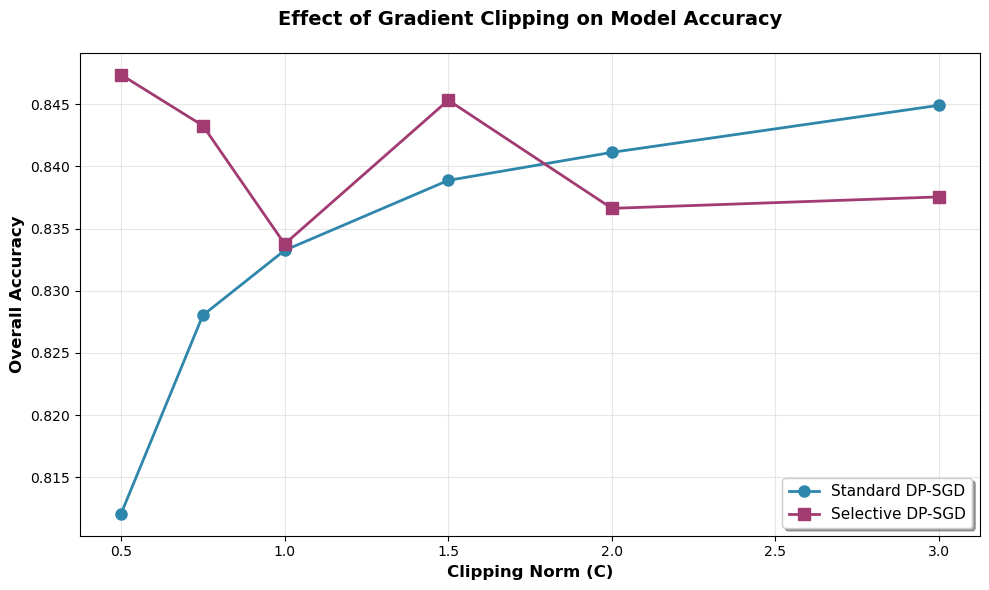

Plot saved to plots/clipping_accuracy.png


In [25]:
# Overall accuracy comparison
plot_clipping_accuracy(clipping_results, save_path='plots/clipping_accuracy.png')

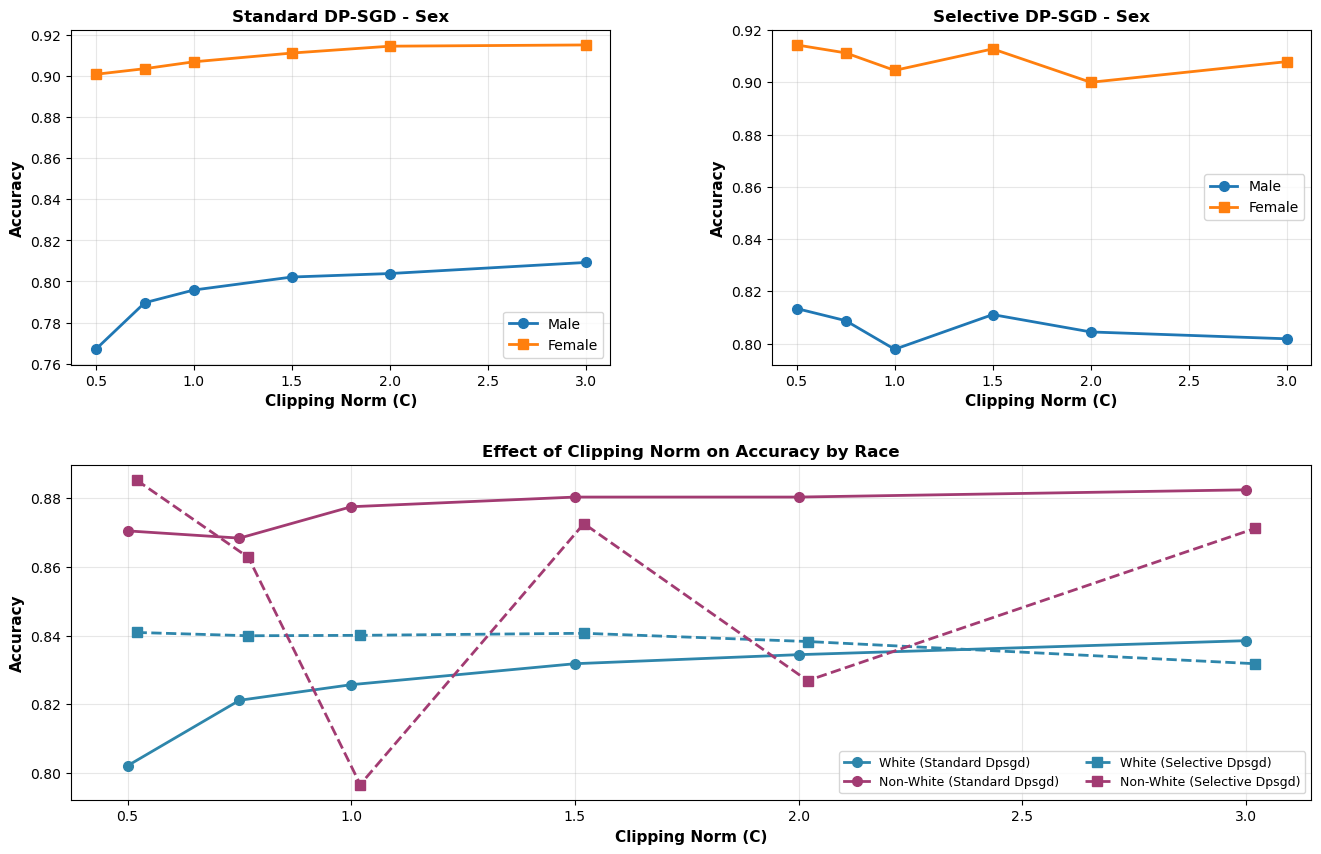

✓ Plot saved to plots/clipping_accuracy_groups.png


In [30]:
# Accuracy broken down by demographic groups
plot_clipping_accuracy_by_groups(clipping_results, save_path='plots/clipping_accuracy_groups.png')

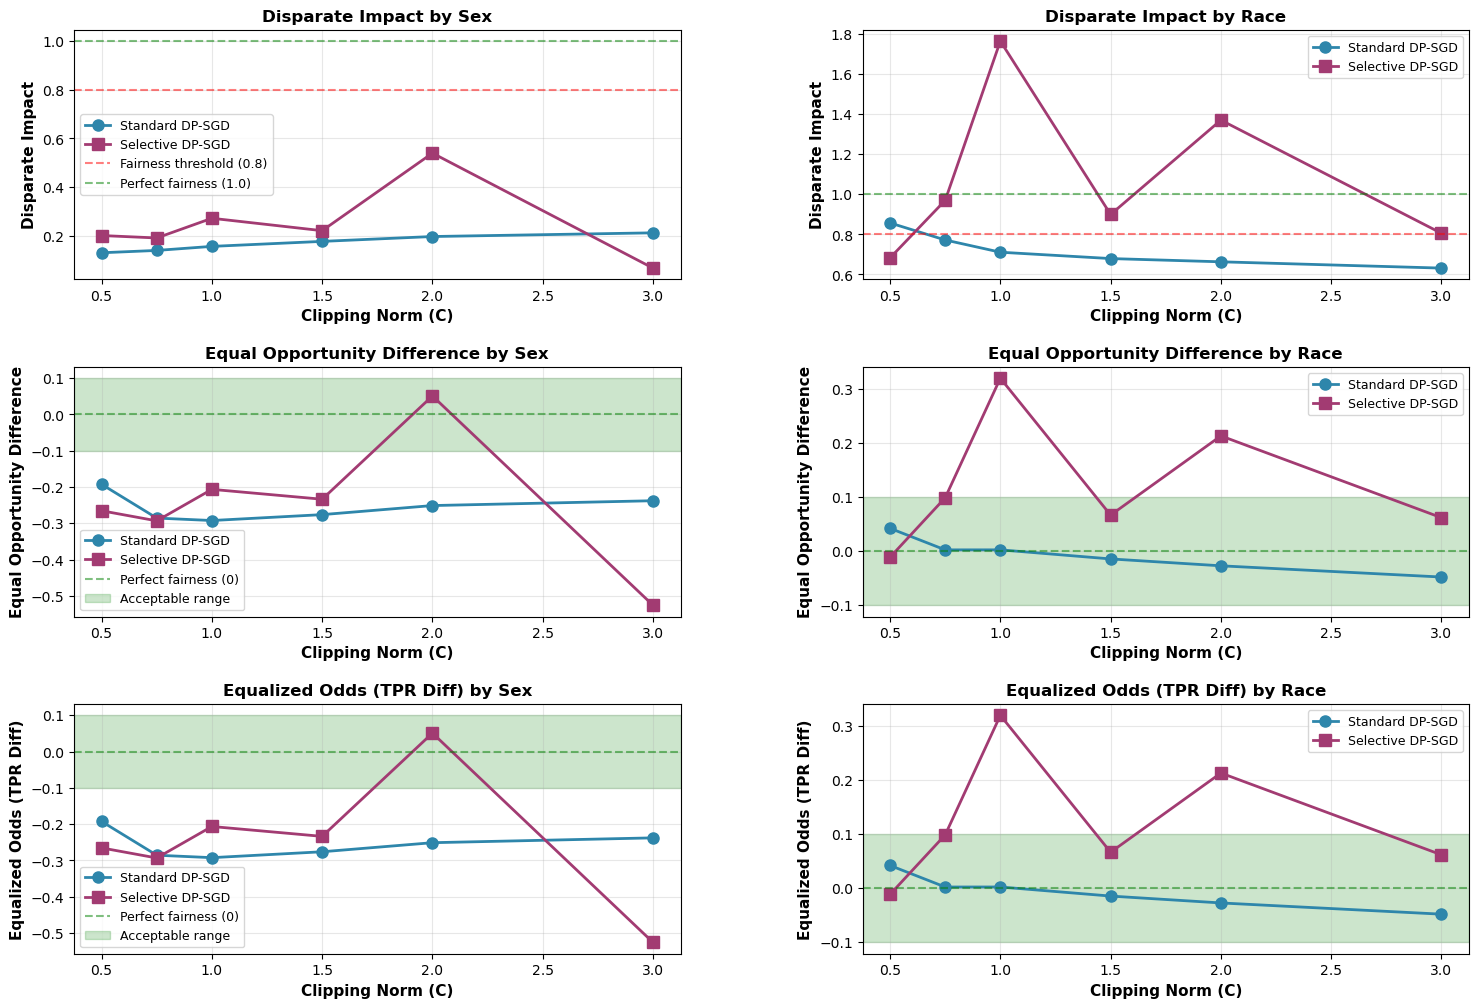

Plot saved to plots/clipping_fairness.png


In [31]:
# Fairness metrics (DI, EO, Equalized Odds)
plot_clipping_fairness(clipping_results, save_path='plots/clipping_fairness.png')

## Noise Plots

In [33]:
def plot_noise_accuracy(results_dict, save_path='noise_accuracy.png'):
    """Plot overall accuracy vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    standard_acc = [results_dict[n]['standard_dpsgd']['accuracy'] for n in noise_multipliers]
    selective_acc = [results_dict[n]['selective_dpsgd']['accuracy'] for n in noise_multipliers]
    
    # Get epsilon values
    standard_eps = [results_dict[n]['standard_dpsgd']['epsilon'] for n in noise_multipliers]
    selective_eps = [results_dict[n]['selective_dpsgd']['epsilon'] for n in noise_multipliers]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Accuracy vs Noise Multiplier
    ax1.plot(noise_multipliers, standard_acc, marker='o', linewidth=2, 
             markersize=8, label='Standard DP-SGD', color='#2E86AB')
    ax1.plot(noise_multipliers, selective_acc, marker='s', linewidth=2, 
             markersize=8, label='Selective DP-SGD', color='#A23B72')
    
    ax1.set_xlabel('Noise Multiplier (σ)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Effect of Noise on Model Accuracy', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(fontsize=11, frameon=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy vs Privacy Budget (Epsilon)
    ax2.plot(standard_eps, standard_acc, marker='o', linewidth=2, 
             markersize=8, label='Standard DP-SGD', color='#2E86AB')
    ax2.plot(selective_eps, selective_acc, marker='s', linewidth=2, 
             markersize=8, label='Selective DP-SGD', color='#A23B72')
    
    ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, 
                label='ε = 1.0 threshold')
    
    ax2.set_xlabel('Privacy Budget (ε)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Overall Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Privacy-Utility Tradeoff', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.legend(fontsize=11, frameon=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_accuracy_by_groups(results_dict, save_path='noise_accuracy_groups.png'):
    """Plot accuracy by demographic groups vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # --- SEX GROUPS ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for model_type, ax, title in [('standard_dpsgd', ax1, 'Standard DP-SGD - Sex'),
                                    ('selective_dpsgd', ax2, 'Selective DP-SGD - Sex')]:
        male_acc = []
        female_acc = []
        
        for n in noise_multipliers:
            # sex_metrics is a tuple: (DataFrame, disparities_dict)
            sex_data = results_dict[n][model_type]['sex_metrics']
            if isinstance(sex_data, tuple):
                sex_metrics, _ = sex_data
            else:
                sex_metrics = sex_data  # Fallback if it's just the DataFrame
            
            male_acc.append(sex_metrics[sex_metrics['group'] == 'Male']['accuracy'].values[0])
            female_acc.append(sex_metrics[sex_metrics['group'] == 'Female']['accuracy'].values[0])
        
        ax.plot(noise_multipliers, male_acc, marker='o', linewidth=2, 
                markersize=7, label='Male', color='#1F77B4')
        ax.plot(noise_multipliers, female_acc, marker='s', linewidth=2, 
                markersize=7, label='Female', color='#FF7F0E')
        
        ax.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # --- RACE GROUPS ---
    ax3 = fig.add_subplot(gs[1, :])
    
    colors = ['#2E86AB', '#A23B72']
    race_groups = ['White', 'Non-White']
    
    for i, model_type in enumerate(['standard_dpsgd', 'selective_dpsgd']):
        race_accs = {group: [] for group in race_groups}
        
        for n in noise_multipliers:
            # race_metrics is a tuple: (DataFrame, disparities_dict)
            race_data = results_dict[n][model_type]['race_metrics']
            if isinstance(race_data, tuple):
                race_metrics, _ = race_data
            else:
                race_metrics = race_data  # Fallback if it's just the DataFrame
            
            for group in race_groups:
                acc_val = race_metrics[race_metrics['group'] == group]['accuracy'].values[0]
                race_accs[group].append(acc_val)
        
        offset = i * 0.02
        for j, group in enumerate(race_groups):
            marker = 'o' if model_type == 'standard_dpsgd' else 's'
            linestyle = '-' if model_type == 'standard_dpsgd' else '--'
            label = f"{group} ({model_type.replace('_', ' ').title()})"
            
            ax3.plot([n + offset for n in noise_multipliers], race_accs[group], 
                    marker=marker, linewidth=2, markersize=7, 
                    label=label, linestyle=linestyle, color=colors[j])
    
    ax3.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of Noise on Accuracy by Race', 
                  fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9, ncol=2, loc='best')
    ax3.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")


def plot_noise_fairness(results_dict, save_path='noise_fairness.png'):
    """Plot fairness metrics vs noise multiplier."""
    noise_multipliers = sorted(results_dict.keys())
    
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)
    
    fairness_metrics = [
        ('disparate_impact', 'Disparate Impact', 0.8, 1.0),
        ('equal_opportunity_difference', 'Equal Opportunity Difference', -0.1, 0.1),
        ('equalized_odds_tpr_diff', 'Equalized Odds (TPR Diff)', -0.1, 0.1),
    ]
    
    for idx, (metric_key, metric_name, lower_bound, upper_bound) in enumerate(fairness_metrics):
        # Sex
        ax1 = fig.add_subplot(gs[idx, 0])
        
        standard_sex = [results_dict[n]['standard_dpsgd']['sex_disparities'][metric_key] 
                        for n in noise_multipliers]
        selective_sex = [results_dict[n]['selective_dpsgd']['sex_disparities'][metric_key] 
                         for n in noise_multipliers]
        
        ax1.plot(noise_multipliers, standard_sex, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax1.plot(noise_multipliers, selective_sex, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, 
                       label='Fairness threshold (0.8)')
            ax1.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (1.0)')
        else:
            ax1.axhline(y=0, color='green', linestyle='--', alpha=0.5, 
                       label='Perfect fairness (0)')
            ax1.axhspan(lower_bound, upper_bound, alpha=0.2, color='green', 
                       label=f'Acceptable range')
        
        ax1.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax1.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax1.set_title(f'{metric_name} by Sex', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9, loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Race
        ax2 = fig.add_subplot(gs[idx, 1])
        
        standard_race = [results_dict[n]['standard_dpsgd']['race_disparities'][metric_key] 
                         for n in noise_multipliers]
        selective_race = [results_dict[n]['selective_dpsgd']['race_disparities'][metric_key] 
                          for n in noise_multipliers]
        
        ax2.plot(noise_multipliers, standard_race, marker='o', linewidth=2, 
                markersize=8, label='Standard DP-SGD', color='#2E86AB')
        ax2.plot(noise_multipliers, selective_race, marker='s', linewidth=2, 
                markersize=8, label='Selective DP-SGD', color='#A23B72')
        
        # Add fairness thresholds
        if metric_key == 'disparate_impact':
            ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
            ax2.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
        else:
            ax2.axhline(y=0, color='green', linestyle='--', alpha=0.5)
            ax2.axhspan(lower_bound, upper_bound, alpha=0.2, color='green')
        
        ax2.set_xlabel('Noise Multiplier (σ)', fontsize=11, fontweight='bold')
        ax2.set_ylabel(metric_name, fontsize=11, fontweight='bold')
        ax2.set_title(f'{metric_name} by Race', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9, loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {save_path}")

In [32]:
# Sweep through different noise multiplier values
noise_results = run_parameter_sweep(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test=y_test,
    X_test_df=X_test,
    sensitive_indices=sensitive_indices,
    param_type='noise',
    param_values=[0.5, 0.75, 1.0, 1.5, 2.0, 2.5],
    fixed_clipping=1.0,
    lr=0.01,
    epochs=10,
    batch_size=64
)


RUNNING NOISE PARAMETER SWEEP
Testing 6 values: [0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
This will train 12 models (Standard + Selective)



Sweeping noise:   0%|          | 0/6 [00:00<?, ?it/s]


--- Testing: noise=0.5 ---
Training Standard DP-SGD...

TRAINING STANDARD DP-SGD MODEL
Hyperparameters:
  - Learning rate: 0.01
  - Epochs: 10
  - Batch size: 64
  - Noise multiplier: 0.5
  - Max grad norm: 1.0
  - Delta (δ): 1e-05


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5153
Epoch 2/10 - Loss: 0.4702
Epoch 3/10 - Loss: 0.4312
Epoch 4/10 - Loss: 0.4048
Epoch 5/10 - Loss: 0.3884
Epoch 6/10 - Loss: 0.3817
Epoch 7/10 - Loss: 0.3822
Epoch 8/10 - Loss: 0.3776
Epoch 9/10 - Loss: 0.3799
Epoch 10/10 - Loss: 0.3862
Training completed

PRIVACY BUDGET
Epsilon (ε): 6.3810
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=6.3810 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=6.381)
Overall Accuracy: 0.8334
AUC-ROC Score: 0.8851

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.230556 0.544394 0.093369  0.796451
Female       0.037701 0.247956 0.011294  0.906050

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1635
Equal Opportunity Difference (TPR diff): -0.2964
Equalized Odds Differences: TPR diff=-0.2964, FPR diff=-0.0821

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  17%|█▋        | 1/6 [00:05<00:26,  5.20s/it]

Epoch 9/10 - Loss: 0.3294
Epoch 10/10 - Loss: 0.3279
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 7.6945
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=7.6945 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=7.694)
Overall Accuracy: 0.8475
AUC-ROC Score: 0.9017

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.257716 0.612887 0.102462  0.810957
Female       0.064457 0.427793 0.018823  0.919428

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.2501
Equal Opportunity Difference (TPR diff): -0.1851
Equalized Odds Differences: TPR diff=-0.1851, FPR diff=-0.0836

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.202444 0.585654 0.072082  0.841040
Non-White       0.1351

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5027
Epoch 2/10 - Loss: 0.4594
Epoch 3/10 - Loss: 0.4185
Epoch 4/10 - Loss: 0.4003
Epoch 5/10 - Loss: 0.3954
Epoch 6/10 - Loss: 0.3844
Epoch 7/10 - Loss: 0.3818
Epoch 8/10 - Loss: 0.3808
Epoch 9/10 - Loss: 0.3795
Epoch 10/10 - Loss: 0.3825
Training completed

PRIVACY BUDGET
Epsilon (ε): 1.3108
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=1.3108 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=1.311)
Overall Accuracy: 0.8334
AUC-ROC Score: 0.8849

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.228086 0.539320 0.092038  0.795833
Female       0.037093 0.250681 0.010267  0.907267

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1626
Equal Opportunity Difference (TPR diff): -0.2886
Equalized Odds Differences: TPR diff=-0.2886, FPR diff=-0.0818

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  33%|███▎      | 2/6 [00:10<00:20,  5.01s/it]

Epoch 8/10 - Loss: 0.3307
Epoch 9/10 - Loss: 0.3299
Epoch 10/10 - Loss: 0.3296
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 1.9514
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=1.9514 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=1.951)
Overall Accuracy: 0.8460
AUC-ROC Score: 0.9003

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.242284 0.589041 0.090707  0.811883
Female       0.043174 0.305177 0.010267  0.913348

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1782
Equal Opportunity Difference (TPR diff): -0.2839
Equalized Odds Differences: TPR diff=-0.2839, FPR diff=-0.0804

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.181481 0.541765 0.058918  0.839

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5057
Epoch 2/10 - Loss: 0.4697
Epoch 3/10 - Loss: 0.4227
Epoch 4/10 - Loss: 0.4014
Epoch 5/10 - Loss: 0.4000
Epoch 6/10 - Loss: 0.3873
Epoch 7/10 - Loss: 0.3864
Epoch 8/10 - Loss: 0.3816
Epoch 9/10 - Loss: 0.3790
Epoch 10/10 - Loss: 0.3808
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.6400
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.6400 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.640)
Overall Accuracy: 0.8317
AUC-ROC Score: 0.8846

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.225926 0.534247 0.091151  0.794907
Female       0.034053 0.223433 0.010267  0.904226

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1507
Equal Opportunity Difference (TPR diff): -0.3108
Equalized Odds Differences: TPR diff=-0.3108, FPR diff=-0.0809

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  50%|█████     | 3/6 [00:14<00:14,  4.87s/it]

Epoch 8/10 - Loss: 0.3322
Epoch 9/10 - Loss: 0.3295
Epoch 10/10 - Loss: 0.3301
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.9219
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.9219 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.922)
Overall Accuracy: 0.8461
AUC-ROC Score: 0.8986

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.252623 0.607306 0.097583  0.812654
Female       0.037701 0.275204 0.007871  0.912131

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1492
Equal Opportunity Difference (TPR diff): -0.3321
Equalized Odds Differences: TPR diff=-0.3321, FPR diff=-0.0897

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.186512 0.554035 0.061487  0.840

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5084
Epoch 2/10 - Loss: 0.4721
Epoch 3/10 - Loss: 0.4282
Epoch 4/10 - Loss: 0.4068
Epoch 5/10 - Loss: 0.3955
Epoch 6/10 - Loss: 0.3851
Epoch 7/10 - Loss: 0.3872
Epoch 8/10 - Loss: 0.3804
Epoch 9/10 - Loss: 0.3761
Epoch 10/10 - Loss: 0.3846
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.3414
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.3414 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.341)
Overall Accuracy: 0.8321
AUC-ROC Score: 0.8849

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.225000 0.531710 0.090929  0.794290
Female       0.034661 0.237057 0.009240  0.906659

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1540
Equal Opportunity Difference (TPR diff): -0.2947
Equalized Odds Differences: TPR diff=-0.2947, FPR diff=-0.0817

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  67%|██████▋   | 4/6 [00:19<00:09,  4.76s/it]

Epoch 8/10 - Loss: 0.3466
Epoch 9/10 - Loss: 0.3462
Epoch 10/10 - Loss: 0.3396
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.4012
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.4012 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.401)
Overall Accuracy: 0.8440
AUC-ROC Score: 0.8938

=== Fairness by sex ===
 group  positive_rate     TPR      FPR  accuracy
  Male       0.262963 0.61999 0.106897  0.810031
Female       0.037093 0.26703 0.008214  0.910915

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1411
Equal Opportunity Difference (TPR diff): -0.3530
Equalized Odds Differences: TPR diff=-0.3530, FPR diff=-0.0987

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.207714 0.589429 0.077862  0.837686

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5136
Epoch 2/10 - Loss: 0.4738
Epoch 3/10 - Loss: 0.4365
Epoch 4/10 - Loss: 0.4010
Epoch 5/10 - Loss: 0.3834
Epoch 6/10 - Loss: 0.3834
Epoch 7/10 - Loss: 0.3808
Epoch 8/10 - Loss: 0.3779
Epoch 9/10 - Loss: 0.3825
Epoch 10/10 - Loss: 0.3808
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.2374
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.2374 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.237)
Overall Accuracy: 0.8344
AUC-ROC Score: 0.8861

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.226080 0.538305 0.089599  0.797222
Female       0.035573 0.245232 0.009240  0.907571

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1573
Equal Opportunity Difference (TPR diff): -0.2931
Equalized Odds Differences: TPR diff=-0.2931, FPR diff=-0.0804

=== Fairness by race_grouped ===
    group  positive_rate

Sweeping noise:  83%|████████▎ | 5/6 [00:24<00:04,  4.81s/it]

Epoch 8/10 - Loss: 0.3429
Epoch 9/10 - Loss: 0.3461
Epoch 10/10 - Loss: 0.3509
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.2543
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.2543 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.254)
Overall Accuracy: 0.8379
AUC-ROC Score: 0.8904

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.269907 0.622019 0.115990  0.804321
Female       0.044086 0.267030 0.016085  0.903922

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1633
Equal Opportunity Difference (TPR diff): -0.3550
Equalized Odds Differences: TPR diff=-0.3550, FPR diff=-0.0999

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.195496 0.569608 0.068229  0.839

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch 1/10 - Loss: 0.5005
Epoch 2/10 - Loss: 0.4722
Epoch 3/10 - Loss: 0.4330
Epoch 4/10 - Loss: 0.4020
Epoch 5/10 - Loss: 0.3911
Epoch 6/10 - Loss: 0.3821
Epoch 7/10 - Loss: 0.3838
Epoch 8/10 - Loss: 0.3815
Epoch 9/10 - Loss: 0.3791
Epoch 10/10 - Loss: 0.3806
Training completed

PRIVACY BUDGET
Epsilon (ε): 0.1833
Delta (δ): 1e-05

Interpretation:
  - ALL features are protected with ε=0.1833 privacy
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Standard DP-SGD (ε=0.183)
Overall Accuracy: 0.8351
AUC-ROC Score: 0.8857

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.222068 0.533739 0.085828  0.798457
Female       0.033445 0.234332 0.008214  0.907267

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.1506
Equal Opportunity Difference (TPR diff): -0.2994
Equalized Odds Differences: TPR diff=-0.2994, FPR diff=-0.0776

=== Fairness by race_grouped ===
    group  positive_rate

/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch 2/10 - Loss: 0.3862
Epoch 3/10 - Loss: 0.3813
Epoch 4/10 - Loss: 0.3892
Epoch 5/10 - Loss: 0.3897
Epoch 6/10 - Loss: 0.3779
Epoch 7/10 - Loss: 0.3691


/Users/enricoalmadani/anaconda3/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
Sweeping noise: 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]

Epoch 8/10 - Loss: 0.3601
Epoch 9/10 - Loss: 0.3618
Epoch 10/10 - Loss: 0.3677
Training completed

PRIVACY BUDGET (SELECTIVE)
Epsilon (ε): 0.1941
Delta (δ): 1e-05

Interpretation:
  - Sensitive features (indices [61, 62, 63, 64, 65, 66, 67]) have ε=0.1941 privacy
  - Non-sensitive features have NO formal privacy guarantee
  - Lower ε = stronger privacy (typical target: ε ≤ 1.0)

EVALUATION: Selective DP-SGD (ε=0.194)
Overall Accuracy: 0.8436
AUC-ROC Score: 0.8768

=== Fairness by sex ===
 group  positive_rate      TPR      FPR  accuracy
  Male       0.242593 0.579909 0.095143  0.806019
Female       0.082092 0.498638 0.029774  0.917604

=== GROUP FAIRNESS DISPARITIES ===
Privileged group: Male, Protected group: Female
Disparate Impact: 0.3384
Equal Opportunity Difference (TPR diff): -0.0813
Equalized Odds Differences: TPR diff=-0.0813, FPR diff=-0.0654

=== Fairness by race_grouped ===
    group  positive_rate      TPR      FPR  accuracy
    White       0.212746 0.611137 0.077219  0.843

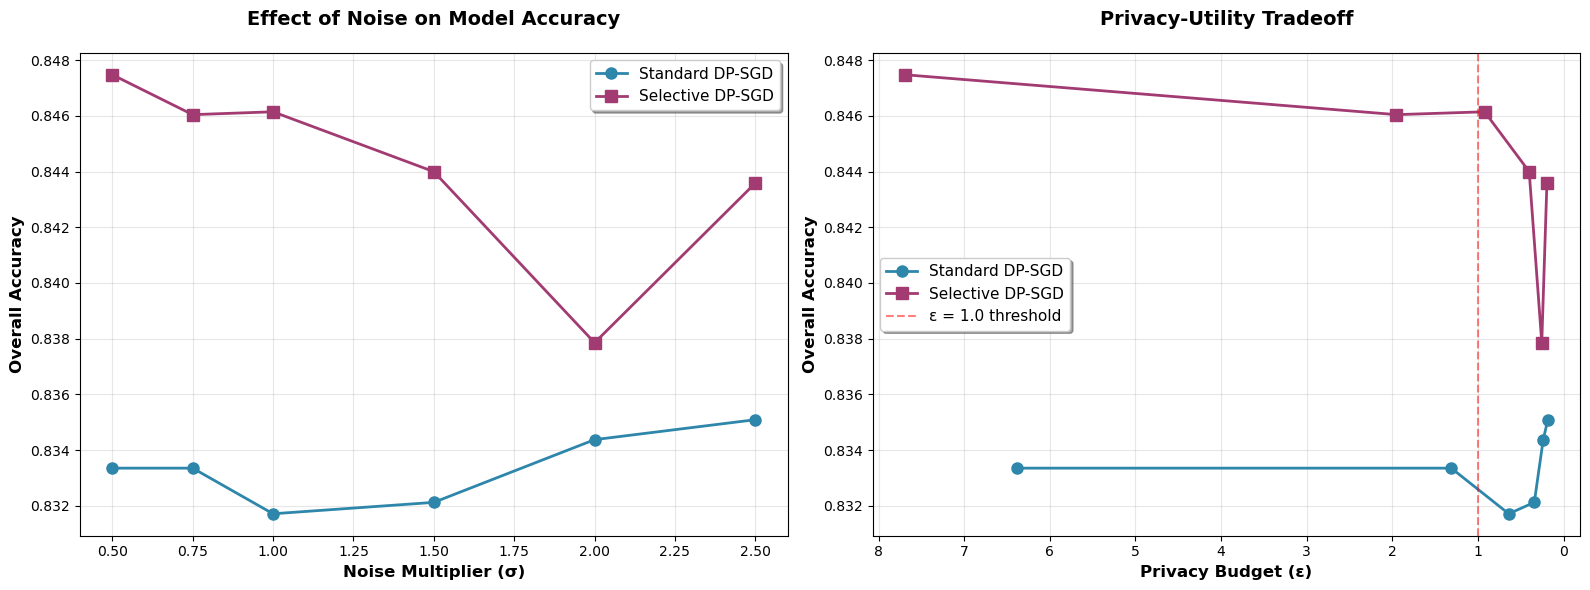

Plot saved to plots/noise_accuracy.png


In [34]:
# Overall accuracy + privacy-utility tradeoff
plot_noise_accuracy(noise_results, save_path='plots/noise_accuracy.png')